<a href="https://colab.research.google.com/github/khushibhatia15/machine-learning-projects/blob/main/Plant_Disease_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Install Required Libraries
!pip install tensorflow kaggle split-folders matplotlib scikit-learn


In [ ]:
# Step 2: Import Libraries
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import splitfolders
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np


In [ ]:
# Step 3: Download and Prepare the Dataset
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d emmarex/plantdisease
!unzip plantdisease.zip -d plant_disease_data


Streaming output truncated to the last 5000 lines.
  inflating: plant_disease_data/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: plant_disease_data/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: plant_disease_data/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: plant_disease_data/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: plant_disease_data/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: plant_disease_data/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 0

In [ ]:
# Step 4: Split the dataset into train, validation, and test sets
splitfolders.ratio('plant_disease_data/PlantVillage', output="plant_disease_data/output",
                   seed=1337, ratio=(.8, .1, .1))


Copying files: 20639 files [00:03, 6490.67 files/s]


In [ ]:
# Step 5: Define Directory Paths
base_dir = 'plant_disease_data/output'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')


In [ ]:
# Step 6: Data Preprocessing
image_size = (224, 224)  # Both VGG16 and ResNet50 expect 224x224 input size
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 16504 images belonging to 15 classes.
Found 2058 images belonging to 15 classes.
Found 2076 images belonging to 15 classes.


In [ ]:
# Step 7: Define and Compile Models

# VGG16 Model
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model_vgg16.layers[:15]:
    layer.trainable = False

model_vgg16 = Sequential([
    base_model_vgg16,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model_vgg16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# ResNet50 Model (Train for 10 epochs)
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model_resnet50.layers[:15]:
    layer.trainable = False

model_resnet50 = Sequential([
    base_model_resnet50,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model_resnet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# Step 8: Train Models
def train_model(model, model_name, epochs=1):
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    # Changed .h5 to .keras
    checkpoint = ModelCheckpoint(f'{model_name}_best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        callbacks=[lr_scheduler, checkpoint]
    )

    return history

# Train VGG16 for 20 epochs
history_vgg16 = train_model(model_vgg16, 'vgg16', epochs=20)

# Train ResNet50 for 10 epochs
history_resnet50 = train_model(model_resnet50, 'resnet50', epochs=10)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


515/515 ━━━━━━━━━━━━━━━━━━━━ 265s 471ms/step - accuracy: 0.5329 - loss: 1.4623 - val_accuracy: 0.8442 - val_loss: 0.4727 - learning_rate: 1.0000e-04
Epoch 2/20
  1/515 ━━━━━━━━━━━━━━━━━━━━ 1:15 148ms/step - accuracy: 0.8750 - loss: 0.4511

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


515/515 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8750 - loss: 0.4511 - val_accuracy: 1.0000 - val_loss: 0.0613 - learning_rate: 1.0000e-04
Epoch 3/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 280s 435ms/step - accuracy: 0.8489 - loss: 0.4528 - val_accuracy: 0.8877 - val_loss: 0.3251 - learning_rate: 1.0000e-04
Epoch 4/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8125 - loss: 0.4340 - val_accuracy: 0.9000 - val_loss: 0.3153 - learning_rate: 1.0000e-04
Epoch 5/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 226s 435ms/step - accuracy: 0.8973 - loss: 0.3155 - val_accuracy: 0.9199 - val_loss: 0.2428 - learning_rate: 1.0000e-04
Epoch 6/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9062 - loss: 0.2492 - val_accuracy: 0.9000 - val_loss: 0.3309 - learning_rate: 5.0000e-05
Epoch 7/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 229s 439ms/step - accuracy: 0.9400 - loss: 0.1738 - val_accuracy: 0.9478 - val_loss: 0.1624 - learning_rate: 5.0000e-05
Epoch 8/20
515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy

In [ ]:
# Step 9: Evaluate Both Models
test_loss_vgg16, test_acc_vgg16 = model_vgg16.evaluate(test_generator, steps=test_generator.samples // batch_size)
test_loss_resnet50, test_acc_resnet50 = model_resnet50.evaluate(test_generator, steps=test_generator.samples // batch_size)

print(f"VGG16 Test accuracy: {test_acc_vgg16:.4f}")
print(f"ResNet50 Test accuracy (10 epochs): {test_acc_resnet50:.4f}")


64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9772 - loss: 0.0834
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.9619 - loss: 0.1997
VGG16 Test accuracy: 0.9727
ResNet50 Test accuracy (10 epochs): 0.9570


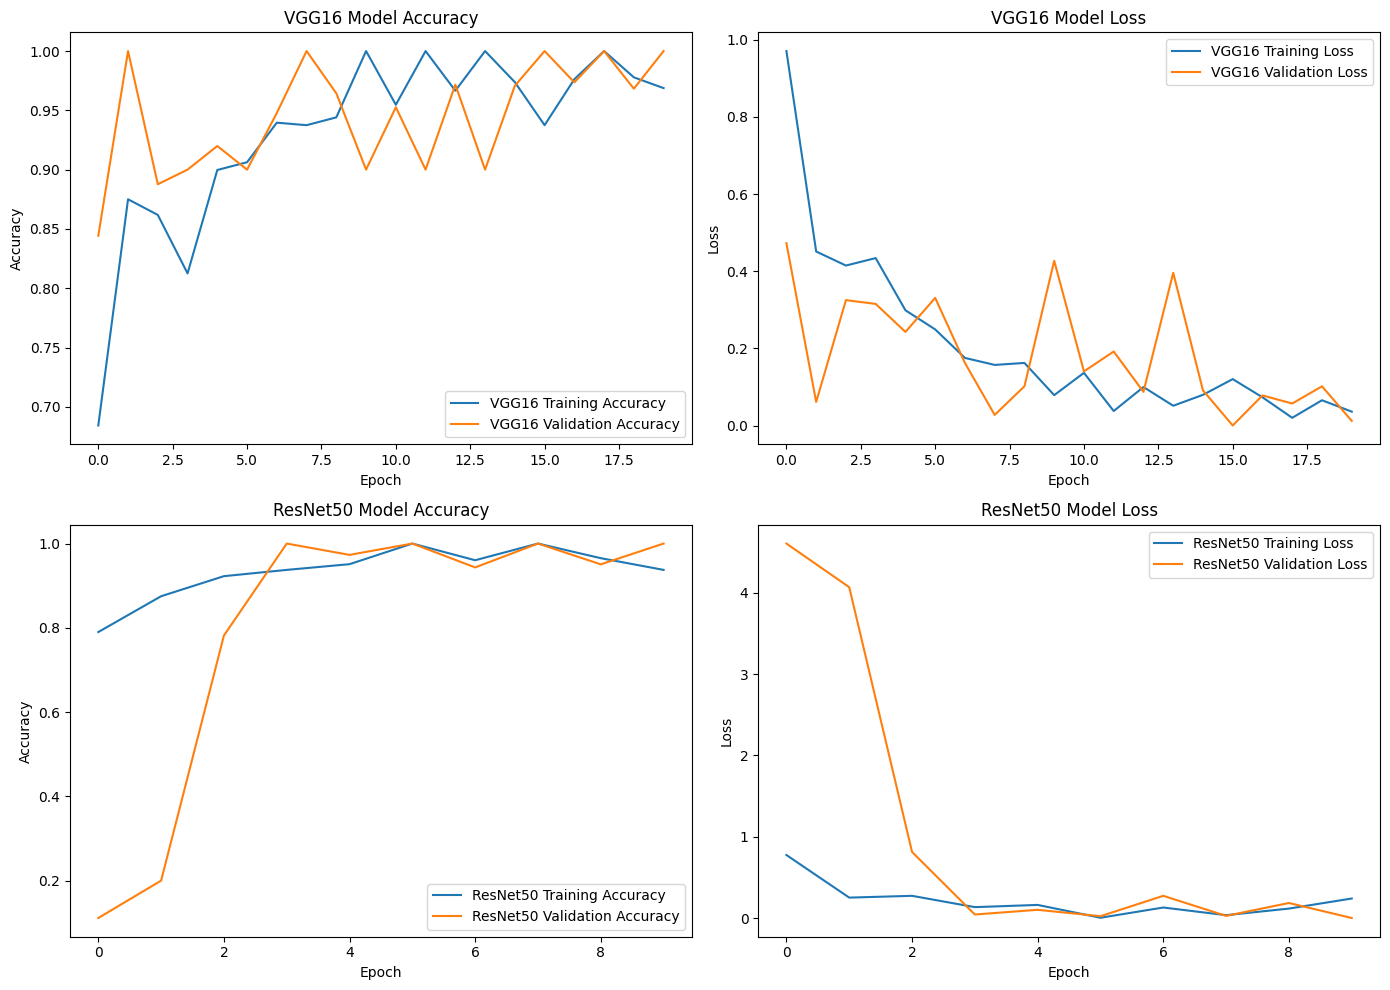

In [ ]:
# Step 10: Plot Training History
plt.figure(figsize=(14, 10))

# VGG16 Accuracy and Loss
plt.subplot(2, 2, 1)
plt.plot(history_vgg16.history['accuracy'], label='VGG16 Training Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='VGG16 Validation Accuracy')
plt.title('VGG16 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history_vgg16.history['loss'], label='VGG16 Training Loss')
plt.plot(history_vgg16.history['val_loss'], label='VGG16 Validation Loss')
plt.title('VGG16 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# ResNet50 Accuracy and Loss
plt.subplot(2, 2, 3)
plt.plot(history_resnet50.history['accuracy'], label='ResNet50 Training Accuracy')
plt.plot(history_resnet50.history['val_accuracy'], label='ResNet50 Validation Accuracy')
plt.title('ResNet50 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history_resnet50.history['loss'], label='ResNet50 Training Loss')
plt.plot(history_resnet50.history['val_loss'], label='ResNet50 Validation Loss')
plt.title('ResNet50 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


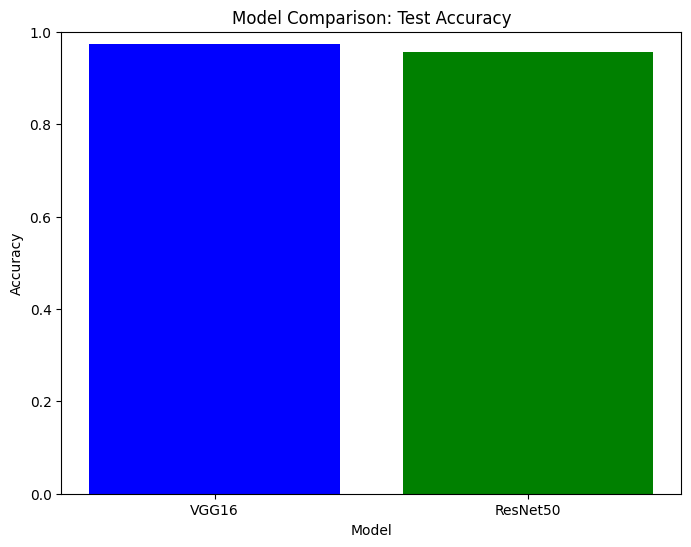

In [ ]:
# Comparison Bar Chart
plt.figure(figsize=(8, 6))
models = ['VGG16', 'ResNet50']
accuracies = [test_acc_vgg16, test_acc_resnet50]

plt.bar(models, accuracies, color=['blue', 'green'])
plt.title('Model Comparison: Test Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.show()


65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 349ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 169ms/step
VGG16 Classification Report:
Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.03      0.03      0.03       101
                     Pepper__bell___healthy       0.05      0.05      0.05       149
                      Potato___Early_blight       0.08      0.08      0.08       100
                       Potato___Late_blight       0.02      0.02      0.02       100
                           Potato___healthy       0.00      0.00      0.00        16
                      Tomato_Bacterial_spot       0.09      0.09      0.09       214
                        Tomato_Early_blight       0.06      0.05      0.05       100
                         Tomato_Late_blight       0.09      0.09      0.09       192
                           Tomato_Leaf_Mold       0.08      0.07      0.08        96
             

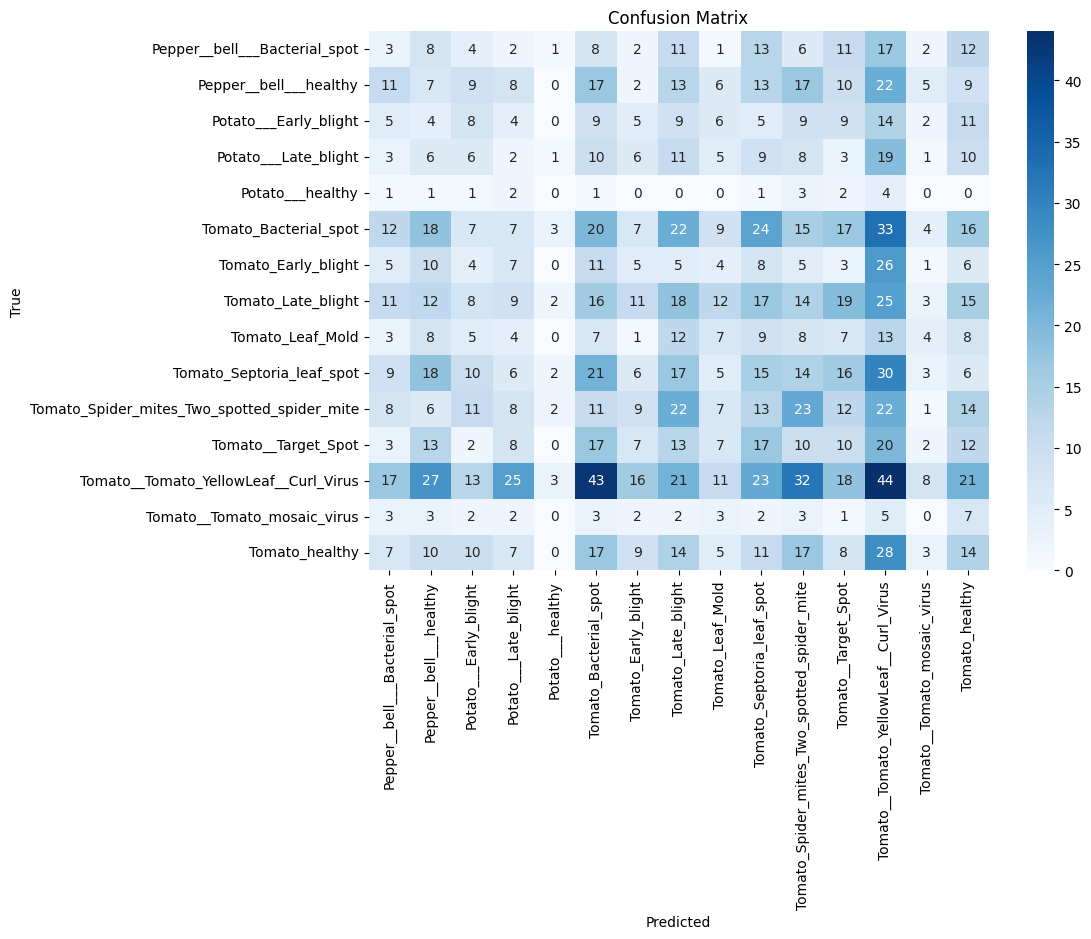

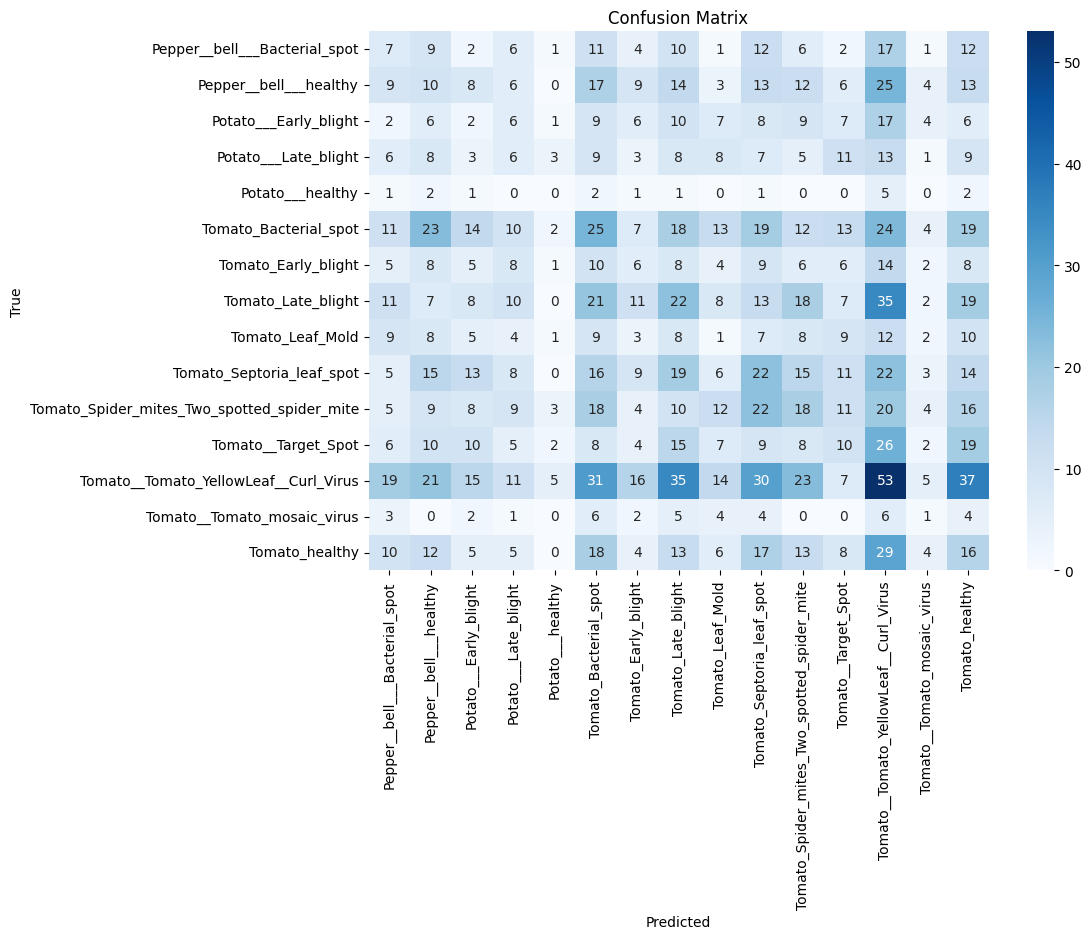

In [ ]:
# Step 11: Confusion Matrix and Classification Report

def get_predictions_and_labels(generator, model):
    predictions = model.predict(generator, steps=generator.samples // batch_size + 1)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())
    return predicted_classes, true_classes, class_labels

def plot_confusion_matrix(true_classes, predicted_classes, class_labels):
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def print_classification_report(true_classes, predicted_classes, class_labels):
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print("Classification Report:")
    print(report)

predicted_classes_vgg16, true_classes_vgg16, class_labels = get_predictions_and_labels(test_generator, model_vgg16)
predicted_classes_resnet50, true_classes_resnet50, _ = get_predictions_and_labels(test_generator, model_resnet50)

print("VGG16 Classification Report:")
print_classification_report(true_classes_vgg16, predicted_classes_vgg16, class_labels)

print("ResNet50 Classification Report:")
print_classification_report(true_classes_resnet50, predicted_classes_resnet50, class_labels)

plot_confusion_matrix(true_classes_vgg16, predicted_classes_vgg16, class_labels)
plot_confusion_matrix(true_classes_resnet50, predicted_classes_resnet50, class_labels)


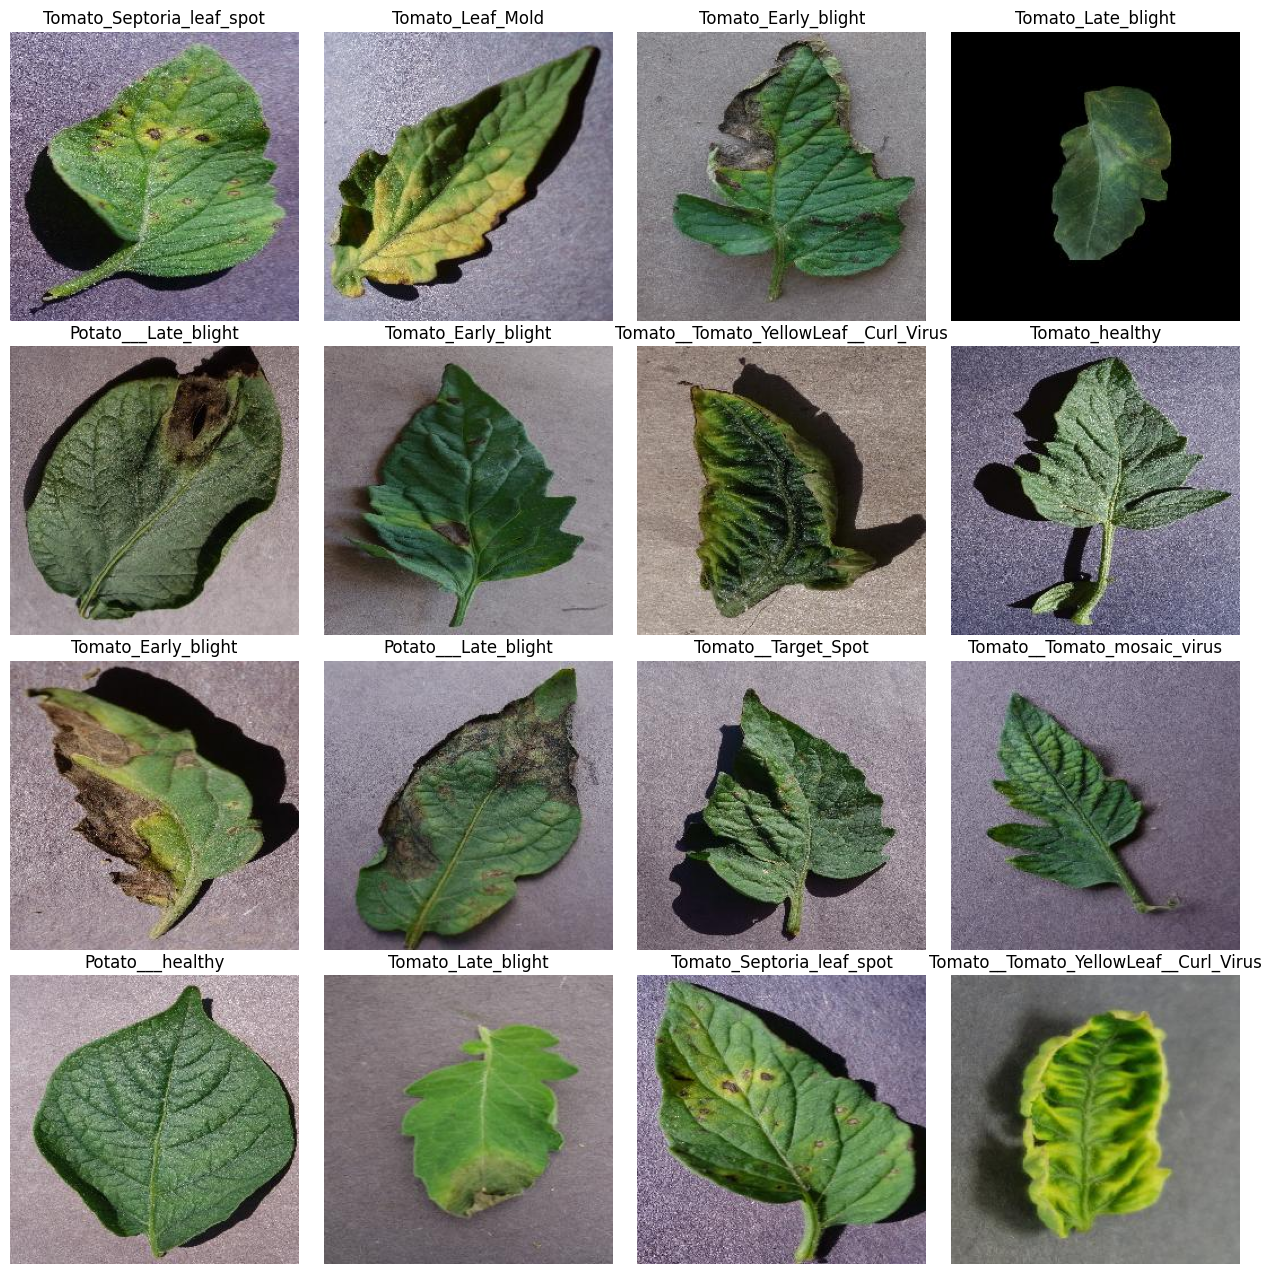

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

# Set up directories to explore
sample_dir = train_dir

# Get a list of disease classes
disease_classes = os.listdir(sample_dir)
disease_classes.sort()

# Plotting a few samples from different classes
plt.figure(figsize=(16, 16))
for i in range(16):
    class_name = random.choice(disease_classes)
    class_path = os.path.join(sample_dir, class_name)
    img_name = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_name)
    img = mpimg.imread(img_path)
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

# Adjust the spacing between subplots (reduce gaps)
plt.subplots_adjust(wspace=0.05, hspace=0.09)

plt.show()
